In [7]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2
from lib import load_checkpoint
import seaborn as sns
from externals.d2net.lib import utils
import imageio

In [13]:
EncoderModule = autoencoder.FeatureEncoder64Up
AttentionModule = attention_model.MultiAttentionLayer2

#resnet parameters
replace_strides = False
use_nms = False # set to false to visualize attention
thresh = 0.8
max_features=None
first_stride=1
use_gpu=False
hpatches_root = "../../hpatches_sequences/hpatches-sequences-release"
hpatches_folders = ["i_bologna"]

encoder_ckpt = load_checkpoint.get_encoder_ckpt('correspondence_encoder')
attention_ckpt = load_checkpoint.get_attention_ckpt('cfe64_multi_attention_model2_distinctiveness+_lossN8_lambda1')

if replace_strides:
    replace_stride_with_dilation = (True, True, True) #(True, True, True) # Default: (False, False, False)
    num_upsampling_extraction = 2
    no_upsampling = True # Set to true when replacing strides
else: 
    replace_stride_with_dilation = (False, False, False)
    num_upsampling_extraction = 3
    no_upsampling = False

if first_stride == 1:
    num_upsampling_extraction -= 1

In [14]:
encoder = EncoderModule.load_from_checkpoint(encoder_ckpt,
                                             no_upsampling=no_upsampling,
                                             replace_stride_with_dilation=replace_stride_with_dilation, 
                                             first_stride=first_stride,
                                             load_tf_weights=False).eval()

attention = AttentionModule.load_from_checkpoint(attention_ckpt, feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, 
                                      use_d2net_detection=False, 
                                      num_upsampling=num_upsampling_extraction, 
                                      thresh=thresh, 
                                      max_features=max_features,
                                      use_nms=use_nms)

if use_gpu:
    extraction_model = extraction_model.cuda()

In [15]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

Number of matches: 1102.
Number of inliers: 719.
Number of matches: 842.
Number of inliers: 532.
Number of matches: 731.
Number of inliers: 380.
Number of matches: 550.
Number of inliers: 243.
Number of matches: 496.
Number of inliers: 136.


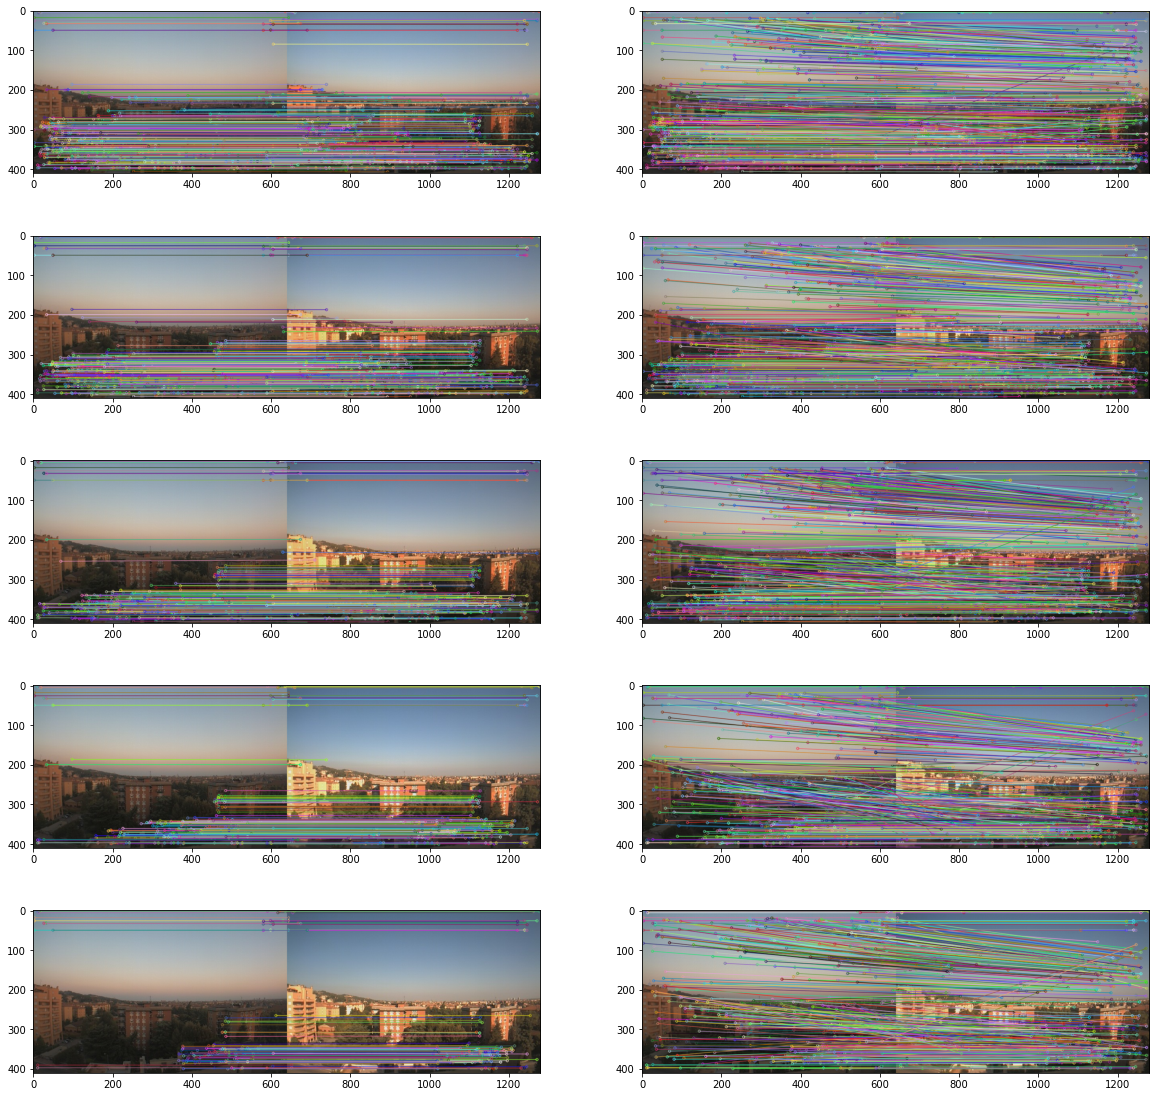

In [16]:
def load_ppm(path):
    image = imageio.imread(path)
    img_proc = utils.preprocess_image(image, preprocessing="torch")
    img_proc = torch.as_tensor(img_proc, dtype=torch.float)
    img_proc = torch.unsqueeze(img_proc, 0)
    if use_gpu:
        img_proc = img_proc.cuda()
    return image, img_proc

match_fun = mnn_matcher # lambda d1, d2: match_descriptors(d1.numpy(), d2.numpy(), cross_check=True)

for cat in hpatches_folders:
    root = os.path.join(hpatches_root, cat)
    paths = [os.path.join(root, f"{i+1}.ppm") for i in range(6)]
    _, axs = plt.subplots(5,2, figsize=(20, 20))
    
    target_np, target = load_ppm(paths[0])
    paths = paths[1:]
    kp1, descr1, scores1, det1 = extraction_model(target)
    
    for i,p in enumerate(paths):
        img_np, img = load_ppm(p)
        kp2, descr2, scores2, det2 = extraction_model(img)
        matches = match_fun(descr1, descr2)
        n_matches = len(matches)
        print('Number of matches: %d.' % n_matches)
        keypoints_left = kp1.numpy()[matches[:, 0], : 2]
        keypoints_right = kp2.numpy()[matches[:, 1], : 2]
        np.random.seed(0)
        model, inliers = ransac(
            (keypoints_left, keypoints_right),
            ProjectiveTransform, min_samples=4,
            residual_threshold=4, max_trials=10000
        )
        n_inliers = np.sum(inliers)
        print('Number of inliers: %d.' % n_inliers)
        inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
        inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
        placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
        image3 = cv2.drawMatches(target_np, inlier_keypoints_left, img_np, inlier_keypoints_right, placeholder_matches, None)
        axs[i, 0].imshow(image3)
        
        inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
        inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
        placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
        image4 = cv2.drawMatches(target_np, inlier_keypoints_left, img_np, inlier_keypoints_right, placeholder_matches, None)
        axs[i, 1].imshow(image4)
    plt.show()